Sample code for problem 7 -- first, use kplr to read in the data

In [1]:
import numpy as np
import kplr

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data

time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux

f.close()

Next, import my_transit helper function and define func1 and func2, which are the two functions to be integrated to compute the flux theory curve (which is the ratio of the integral(func1)/integral(func2)).

In [2]:
import my_transit

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

## Problem 1

In [3]:
# figure out correct place to extract data
r1_ix = np.where(time < 125)
r2_ix = np.where(time > 124)

# extract data between 124 and 125 t
time_extract = time[170:218]
flux_extract = flux[170:218]
flux_err_extract = flux_err[170:218]

In [4]:
time_extract

array([ 124.013216  ,  124.0336506 ,  124.054085  ,  124.0745195 ,
        124.094954  ,  124.1153885 ,  124.135823  ,  124.1562575 ,
        124.1766921 ,  124.1971265 ,  124.217561  ,  124.2379955 ,
        124.25843   ,  124.2788645 ,  124.299299  ,  124.31973359,
        124.34016799,  124.36060249,  124.38103699,  124.40147149,
        124.42190599,  124.44234049,  124.46277509,  124.48320949,
        124.50364398,  124.52407838,  124.54451298,  124.56494748,
        124.58538188,  124.60581648,  124.62625097,  124.64668547,
        124.66711987,  124.68755447,  124.70798897,  124.72842336,
        124.74885796,  124.76929246,  124.78972686,  124.81016135,
        124.83059595,  124.85103035,  124.87146485,  124.89189934,
        124.91233394,  124.93276834,  124.95320283,  124.97363743])

In [5]:
flux_extract

array([ 104186.8125   ,  104175.7265625,  104183.125    ,  104161.03125  ,
        104177.140625 ,  104169.2578125,  104180.8515625,  104151.0234375,
        104183.9609375,  104171.3359375,  104176.8671875,  104187.3046875,
        104189.578125 ,  104187.6796875,  104181.2578125,  104175.7734375,
        104179.578125 ,  104179.9296875,  104179.4296875,  104082.0390625,
        103619.6328125,  103486.2109375,  103454.1640625,  103412.9921875,
        103405.578125 ,  103392.3828125,  103434.1953125,  103486.5703125,
        103571.3125   ,  103979.7265625,  104176.4609375,  104172.515625 ,
        104163.953125 ,  104172.015625 ,  104171.5625   ,  104194.4765625,
        104180.9453125,  104157.109375 ,  104182.9765625,  104176.453125 ,
        104179.4296875,  104176.6875   ,  104181.3671875,  104176.25     ,
        104182.890625 ,  104185.484375 ,  104192.1640625,  104184.2734375], dtype=float32)

In [6]:
def normalize_loop(time, flux, flux_err):
    f_avg = np.mean(flux)
    f_std = np.std(flux)
    
    keep_ix = np.where((abs(flux - f_avg) / f_std) < 2)
    
    return time[keep_ix], flux[keep_ix], flux_err[keep_ix]

def normalize(time, flux, flux_err, n_loops):
    """ Run the normalization algorithm n_loops times, and return new
        time, flux, and flux_err arrays with the proper values dropped,
        as well as the final average flux we will use for normalization.
    """
    n = len(flux)
    print("Starting with {} data points.".format(n))
    for i in range(n_loops):
        time, flux, flux_err = normalize_loop(time, flux, flux_err)
        n_new = len(flux)
        print("On iteration {}, dropped {} data points.".format(i, n - n_new))
        n = n_new
    
    print("Done normalizing. Final # points: {}".format(len(flux)))
    final_avg = np.mean(flux)
    print("Final Avg. Flux:                  {}".format(final_avg))
    
    return time, flux, flux_err, final_avg

In [7]:
# clip some points from flux and compute the avg
NORM_LOOPS = 5
time_reduced, flux_reduced, flux_err_reduced, avg = normalize(time_extract, flux_extract, flux_err_extract, NORM_LOOPS)

Starting with 48 data points.
On iteration 0, dropped 7 data points.
On iteration 1, dropped 2 data points.
On iteration 2, dropped 2 data points.
On iteration 3, dropped 2 data points.
On iteration 4, dropped 3 data points.
Done normalizing. Final # points: 32
Final Avg. Flux:                  104179.90625


In [8]:
# normalize the values
flux_norm = flux_extract / avg
flux_err_norm = flux_err_extract / avg

print("Normalized Flux Array: {}".format(str(flux_norm)))

Normalized Flux Array: [ 1.00006628  0.99995989  1.00003088  0.9998188   0.99997348  0.99989778
  1.00000906  0.99972278  1.00003886  0.99991775  0.99997085  1.00007105
  1.00009286  1.00007463  1.00001299  0.9999603   0.99999684  1.00000024
  0.99999541  0.99906057  0.99462205  0.99334139  0.99303377  0.99263859
  0.99256742  0.99244076  0.99284208  0.99334484  0.99415827  0.99807853
  0.99996692  0.99992907  0.99984688  0.99992424  0.99991989  1.00013983
  1.00001001  0.99978119  1.00002944  0.99996686  0.99999541  0.99996912
  1.00001407  0.99996489  1.00002861  1.00005352  1.00011766  1.00004196]


In [9]:
from scipy import integrate, stats

def flux_theoretical(time, p, t_0, tau):
    """ Convert from Time to z and compute predicted transit curve """
    norm_t = (time - t_0) / tau
    flux_ratio_list = []
    for t in norm_t:
        flux_obsc, flux_obsc_err = integrate.quad(func1, 0.0, 1.0, args=(p, t))
        flux_unobsc, flux_unobsc_err = integrate.quad(func2, 0.0, 1.0, args=(p, t))
        flux_ratio_list.append(flux_obsc / flux_unobsc)
        
    return np.array(flux_ratio_list)

In [10]:
def chi_squared(flux, flux_theory, flux_err):
    s = 0
    for f, ft, fe in zip(flux, flux_theory, flux_err):
        square = ((f - ft) / fe) ** 2
        s += square
    return s

In [11]:
def p1_driver(flux_norm, flux_err_norm):
    # first guess
    PARAMS = {
        'p': 0.0775,
        'tau': 0.1,
        't_0': 124.51
    }

    # compute theoretical flux
    flux_theory = flux_theoretical(time_extract, PARAMS['p'], PARAMS['t_0'], PARAMS['tau'])

    # compute chi squared
    chi_squared_p1 = chi_squared(flux_norm, flux_theory, flux_err_norm)
    
    return flux_theory, chi_squared_p1

In [12]:
flux_theory, p1_chi_squared = p1_driver(flux_norm, flux_err_norm)
print("Chi Squared Value: {}".format(p1_chi_squared))

Chi Squared Value: 464.86291839888656


## Problem 2
##### Is this a good fit or not? To answer this question, first plot the data and the predicted transit curve.

In [13]:
import matplotlib.pyplot as plt

def plot_overlaid(time, flux1, flux2):
    fig, ax1 = plt.subplots()
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    ax1.plot(time, flux1, 'b-')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Flux Ratio (Observed Data)', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(time, flux2, 'r-')
    ax2.set_ylabel('Flux Ratio (Predicted)', color='r')
    ax2.tick_params('y', colors='r')

    plt.show()

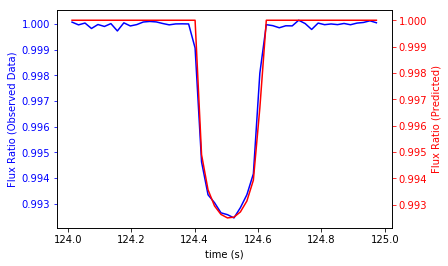

In [14]:
plot_overlaid(time_extract, flux_norm, flux_theory)

##### Before going any further, determine by eye if you think the fit is good or not.

The fit seems pretty good by eye! The red and blue are very close.

In [15]:
# calculate degrees freedom
n_points = len(flux_norm)
n_params = 3
deg_free = n_points - n_params

print("degrees freedom: {}".format(deg_free))

degrees freedom: 45


I calculated the p value using:

`http://www.socscistatistics.com/pvalues/chidistribution.aspx`

and got a value < 0.0001 (very unlikely model params).

## Problem 3